<a href="https://colab.research.google.com/github/obeabi/Stats/blob/main/RandomizedDesign_GroceryWebsiteData_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Scenario: Grocery Store App Experiment
You are an analyst for a large grocery chain. One of the company's main goals 
is to drive more customers to download their mobile app and register for their loyalty program. One way of driving customers to download the app is via a link on the company website.

Page viewing statistics show that only 10% of people who visit the main page are clicking through to visit the page that describes the app and loyalty program.

Your manager has asked you set up an experiment to test whether changing the button of the page link to a picture would improve click through rates of visitors who visit the page that describes the app and loyalty program.

In [4]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind,chi2 , chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

Libraries installed successfully!


In [6]:
# load dataset
df = pd.read_csv('grocerywebsiteabtestdata.csv', usecols= ['RecordID', 'IP Address', 'LoggedInFlag', 'ServerID',\
                    'VisitPageFlag'])

df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [7]:
# Inspect dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184588 entries, 0 to 184587
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   RecordID       184588 non-null  int64 
 1   IP Address     184588 non-null  object
 2   LoggedInFlag   184588 non-null  int64 
 3   ServerID       184588 non-null  int64 
 4   VisitPageFlag  184588 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.0+ MB


In [8]:
# Check for missing values
df.isna().sum()

RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64

In [9]:
# Examine target flag
df.VisitPageFlag.value_counts()

0    173848
1     10740
Name: VisitPageFlag, dtype: int64

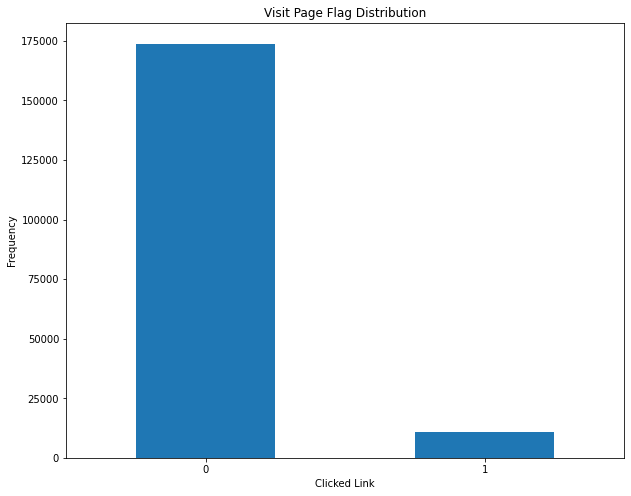

In [10]:
# Visualize counts in target variable
count_classes = pd.value_counts(df['VisitPageFlag'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Visit Page Flag Distribution")
plt.xticks(range(2))
plt.xlabel("Clicked Link")
plt.ylabel('Frequency')
plt.show()

## Data Wrangling

In [11]:
# Filter out already logged in users
df1 = df[df.LoggedInFlag != 1].reset_index(drop = True)
df1.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,4,124.8.220.3,0,3,0
1,5,60.10.192.7,0,2,0
2,8,97.6.126.6,0,3,1
3,11,32.6.213.1,0,2,0
4,13,188.13.62.2,0,3,0


In [12]:
## Ensure each user/IP address is counted for once irrrespetive of time he or she visit website
df2 = df1[['IP Address', 'ServerID','VisitPageFlag']]

df_grp = df2.groupby(['IP Address', 'ServerID'], as_index= False).sum()

df_grp.head()

,IP Address,ServerID,VisitPageFlag
0,0.0.108.2,1,0
1,0.0.111.8,3,0
2,0.0.163.1,2,0
3,0.0.181.9,1,1
4,0.0.20.3,1,0


In [13]:
df_grp.shape

(49513, 3)

In [14]:
df_grp.VisitPageFlag.value_counts()

0    39535
1     9238
2      719
3       20
4        1
Name: VisitPageFlag, dtype: int64

In [15]:
df_grp['groups'] = np.where(df_grp.ServerID == 1, 'Test', 'Control')
df_grp.head()

,IP Address,ServerID,VisitPageFlag,groups
0,0.0.108.2,1,0,Test
1,0.0.111.8,3,0,Control
2,0.0.163.1,2,0,Control
3,0.0.181.9,1,1,Test
4,0.0.20.3,1,0,Test


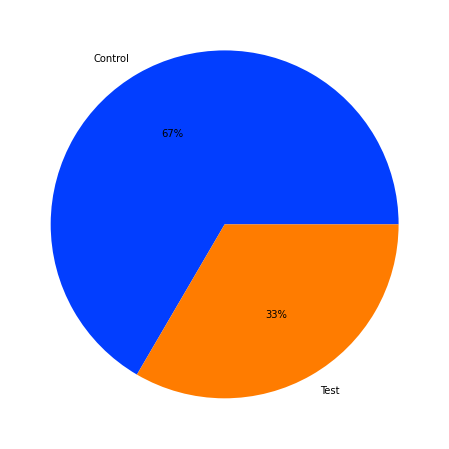

In [16]:
# Visualize counts in target variable
count_classes = pd.value_counts(df_grp['groups'], sort = True)
data = count_classes.values
keys  = count_classes.index
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [17]:
# Create Clicked column based on wheteher user clicked on link or not 
df_grp['clicked'] = np.where(df_grp.VisitPageFlag >= 1, 1, 0)
df_grp.head()

,IP Address,ServerID,VisitPageFlag,groups,clicked
0,0.0.108.2,1,0,Test,0
1,0.0.111.8,3,0,Control,0
2,0.0.163.1,2,0,Control,0
3,0.0.181.9,1,1,Test,1
4,0.0.20.3,1,0,Test,0


In [18]:
# Extract final dataset
df_test = df_grp[['groups', 'clicked']]
df_test.head()

,groups,clicked
0,Test,0
1,Control,0
2,Control,0
3,Test,1
4,Test,0


In [19]:
# Using pingouin library
data_group_test = df_test[df_test.groups == 'Test']. reset_index(drop = True)
data_group_control = df_test[df_test.groups == 'Control']. reset_index(drop = True)

result = pg.ttest(data_group_test.clicked.values, data_group_control.clicked.values, correction= True)

print(result)

                T          dof alternative         p-val         CI95%  \
T-test  11.879473  30817.42101   two-sided  1.781697e-32  [0.04, 0.05]   

         cohen-d       BF10  power  
T-test  0.116313  4.185e+28    1.0  


## Interpreting the result

 The p-value of the test comes out to be <<  significance level alpha (that is, 0.05). This implies that we can say that the click in treatment class is statistically  different from the control grou. Also, the Cohen’s D that is obtained in a t-test is in terms of the relative strength. According to Cohen:

cohen-d = 0.2 is considered as the ‘small’ effect size
cohen-d = 0.5 is considered as the ‘medium’ effect size
cohen-d = 0.8 is considered as the ‘large’ effect size


In [20]:
# Using Scipy Ttest for two-sampled test

data_group_test = df_test[df_test.groups == 'Test']. reset_index(drop = True)
data_group_control = df_test[df_test.groups == 'Control']. reset_index(drop = True)

ttest_ind(data_group_test.clicked.values, data_group_control.clicked.values)

Ttest_indResult(statistic=12.207781132294082, pvalue=3.1641578097185367e-34)

## Chi-Squared Test

In [21]:
df_test.head()

,groups,clicked
0,Test,0
1,Control,0
2,Control,0
3,Test,1
4,Test,0


In [22]:
# Using pingouin library
expected, observed, stats = pg.chi2_independence(df_test, x ='groups', y ='clicked')

expected

clicked,0,1
groups,,
Control,26325.792216,6644.207784
Test,13209.207784,3333.792216


In [23]:
# Observed
observed

clicked,0,1
groups,,
Control,26838.5,6131.5
Test,12696.5,3846.5


In [24]:
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,148.299,1.0,0.0,0.055,1.0
1,cressie-read,0.667,147.430,1.0,0.0,0.055,1.0
2,log-likelihood,0.000,145.799,1.0,0.0,0.054,1.0
3,freeman-tukey,-0.500,144.667,1.0,0.0,0.054,1.0
4,mod-log-likelihood,-1.000,143.609,1.0,0.0,0.054,1.0
5,neyman,-2.000,141.710,1.0,0.0,0.053,1.0


Very low p-values indeed. The group qualifies as a good predictor for the clicks on this dataset.

In [25]:
# Scipy METHOD
data = [[26839, 6131], [12697, 3847]]
stat, p, dof, expected = chi2_contingency(data)


# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 4.2509752776597744e-34
Dependent (reject H0)


In [26]:
stat

148.21794965229287

In [27]:
observed

clicked,0,1
groups,,
Control,26838.5,6131.5
Test,12696.5,3846.5


In [28]:
# Percentage of users that clicked from control group
control = observed.iloc[0,:]
print("Percentage of user sin control grooup that clicked on link :", control[1]/(control[0]+control[1])*100, '%')


Percentage of user sin control grooup that clicked on link : 18.597209584470733 %


In [29]:
# Percentage of users that clicked from treatment group
treatment = observed.iloc[1,:]
print("Percentage of users in treatment grooup that clicked on link :", treatment[1]/(treatment[0]+treatment[1])*100, '%')

Percentage of users in treatment grooup that clicked on link : 23.25152632533398 %


In [30]:
lift = (treatment[1]/(treatment[0]+treatment[1])) - ( control[1]/(control[0]+control[1]))
print("Percentage lift due to treament variant is :", lift*100, '%')

Percentage lift due to treament variant is : 4.654316740863249 %
